# NLP Experiment

Subject : Natural Language Processing

Professsor: Adriano Veloso

Student : Jackson Smith

# Introduction

In this project we aim to build a POS tagger using Keras and a bidirectional LSTM layer for the Portuguese language. A tag analysis was also performed.


The USP macmorpho dataset was used (http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf)

The Dataset is made available through a large file with all the sentences, but to perform the treatment and analysis, each sentence was broken by the parameter "." through the "read_data" function.

This experiment showed better accuracy when trained in 20 epocas which was also the maximum of times trained.

## Task

###  Functions

In [ ]:
def read_data(path_data):

    sentences = []

    with open (path_data) as myfile:
        for line in myfile:
            lineFile = line.split(".")
            line = str.split(str.strip(line), ' ')
            item = []

            for word in line:
                string_word = str.split(str.strip(word), '_')
                item.append(string_word)

            sentences.append(item)
    return sentences

In [ ]:
import numpy as np
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [ ]:
def separe_sentence_tags(tagged_sentences): 
    import numpy as np
 
    sentences, sentence_tags =[], [] 

    for tagged_sentence in tagged_sentences:
        sentence, tags = zip(*tagged_sentence)
        sentences.append(np.array(sentence))
        sentence_tags.append(np.array(tags))
    return sentences, sentence_tags

In [ ]:
def create_word2index_tag2index(all_sentences, all_tags):
    words, tags = set([]), set([])

    for s in all_sentences:
        for w in s:
            words.add(w.lower())

    for ts in all_tags:
        for t in ts:
            tags.add(t)

    word2index = {w: i + 2 for i, w in enumerate(list(words))}
    word2index['-PAD-'] = 0  # The special value used for padding
    word2index['-OOV-'] = 1  # The special value used for OOVs

    tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
    tag2index['-PAD-'] = 0  # The special value used to padding
    return word2index, tag2index

In [ ]:
def create_sentences_tags_to_number(sentences_nlp, tags_nlp, word2index, tag2index):
    sentences_X, tags_y = [], []
 
    for s in sentences_nlp:
        s_int = []
        for w in s:
            try:
                s_int.append(word2index[w.lower()])
            except KeyError:
                s_int.append(word2index['-OOV-'])

        sentences_X.append(s_int)

    for s in tags_nlp:
        tags_y.append([tag2index[t] for t in s])
        
    
    print(sentences_X[0])
    print(tags_y[0])
    
    return sentences_X, tags_y

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

In [ ]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [ ]:
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

### Building train sentences

In [ ]:
sentences_train = read_data("./macmorpho-v3/macmorpho-train.txt")

In [ ]:
sentences_nlp_train, tags_nlp_train = separe_sentence_tags(sentences_train)

In [ ]:
word2index, tag2index = create_word2index_tag2index(sentences_nlp_train, tags_nlp_train)

In [ ]:
tag2index

In [ ]:
word2index

In [ ]:
train_sentences_X, train_tags_y = create_sentences_tags_to_number(sentences_nlp_train, tags_nlp_train, word2index, tag2index)

In [ ]:
MAX_LENGTH_test = len(max(train_sentences_X, key=len))

### Building test sentences

In [ ]:
sentences_test = read_data("./macmorpho-v3/macmorpho-test.txt")

In [ ]:
sentences_nlp_test, tags_nlp_test = separe_sentence_tags(sentences_test)

In [ ]:
test_sentences_X, test_tags_y = create_sentences_tags_to_number(sentences_nlp_test, tags_nlp_test, word2index, tag2index)

In [ ]:
MAX_LENGTH_test = len(max(test_sentences_X, key=len))

### Create Model and Validate

### Get the bigger Max_LENGTH 

In [ ]:
MAX_LENGTH = max(MAX_LENGTH_test, MAX_LENGTH_train)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
 
 
model = Sequential()

model.add(InputLayer(input_shape=( MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])
 
model.summary()

In [2]:
# Descomentar apenas se for treinar o modelo, realizei na primeira vez e depois só carreguei os pesos e arquitetura


# model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=20, validation_split=0.2)

In [3]:
# Salvando o modelo em arquivo


# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

In [ ]:
## Caregando o Modelo existente

from keras.models import model_from_json
from keras.optimizers import Adam


json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model.h5")
print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])

In [32]:
if 'loaded_model' in locals():
    print("modelo carregado")
else:
    print("modelo instanciado")
    loaded_model = model


null


In [33]:
scores = loaded_model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{loaded_model.metrics_names[1]}: {scores[1] * 100}")

9987/9987 [==============================] - 132s 13ms/step
accuracy: 99.50588941574097


##  Confusion Matrix

In [34]:
y_pred = loaded_model.predict_classes(test_sentences_X)

In [35]:
labels = list(tag2index.keys())

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer


y_true_plot = np.concatenate(test_tags_y)
y_pred_plot = np.concatenate(y_pred)

Confusion matrix, without normalization


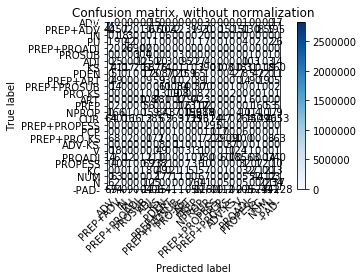

In [37]:
fig,ax = plot_confusion_matrix(y_true_plot, y_pred_plot, classes= labels,
                      title='Confusion matrix, without normalization')

##  Confusion matrix without Normalization

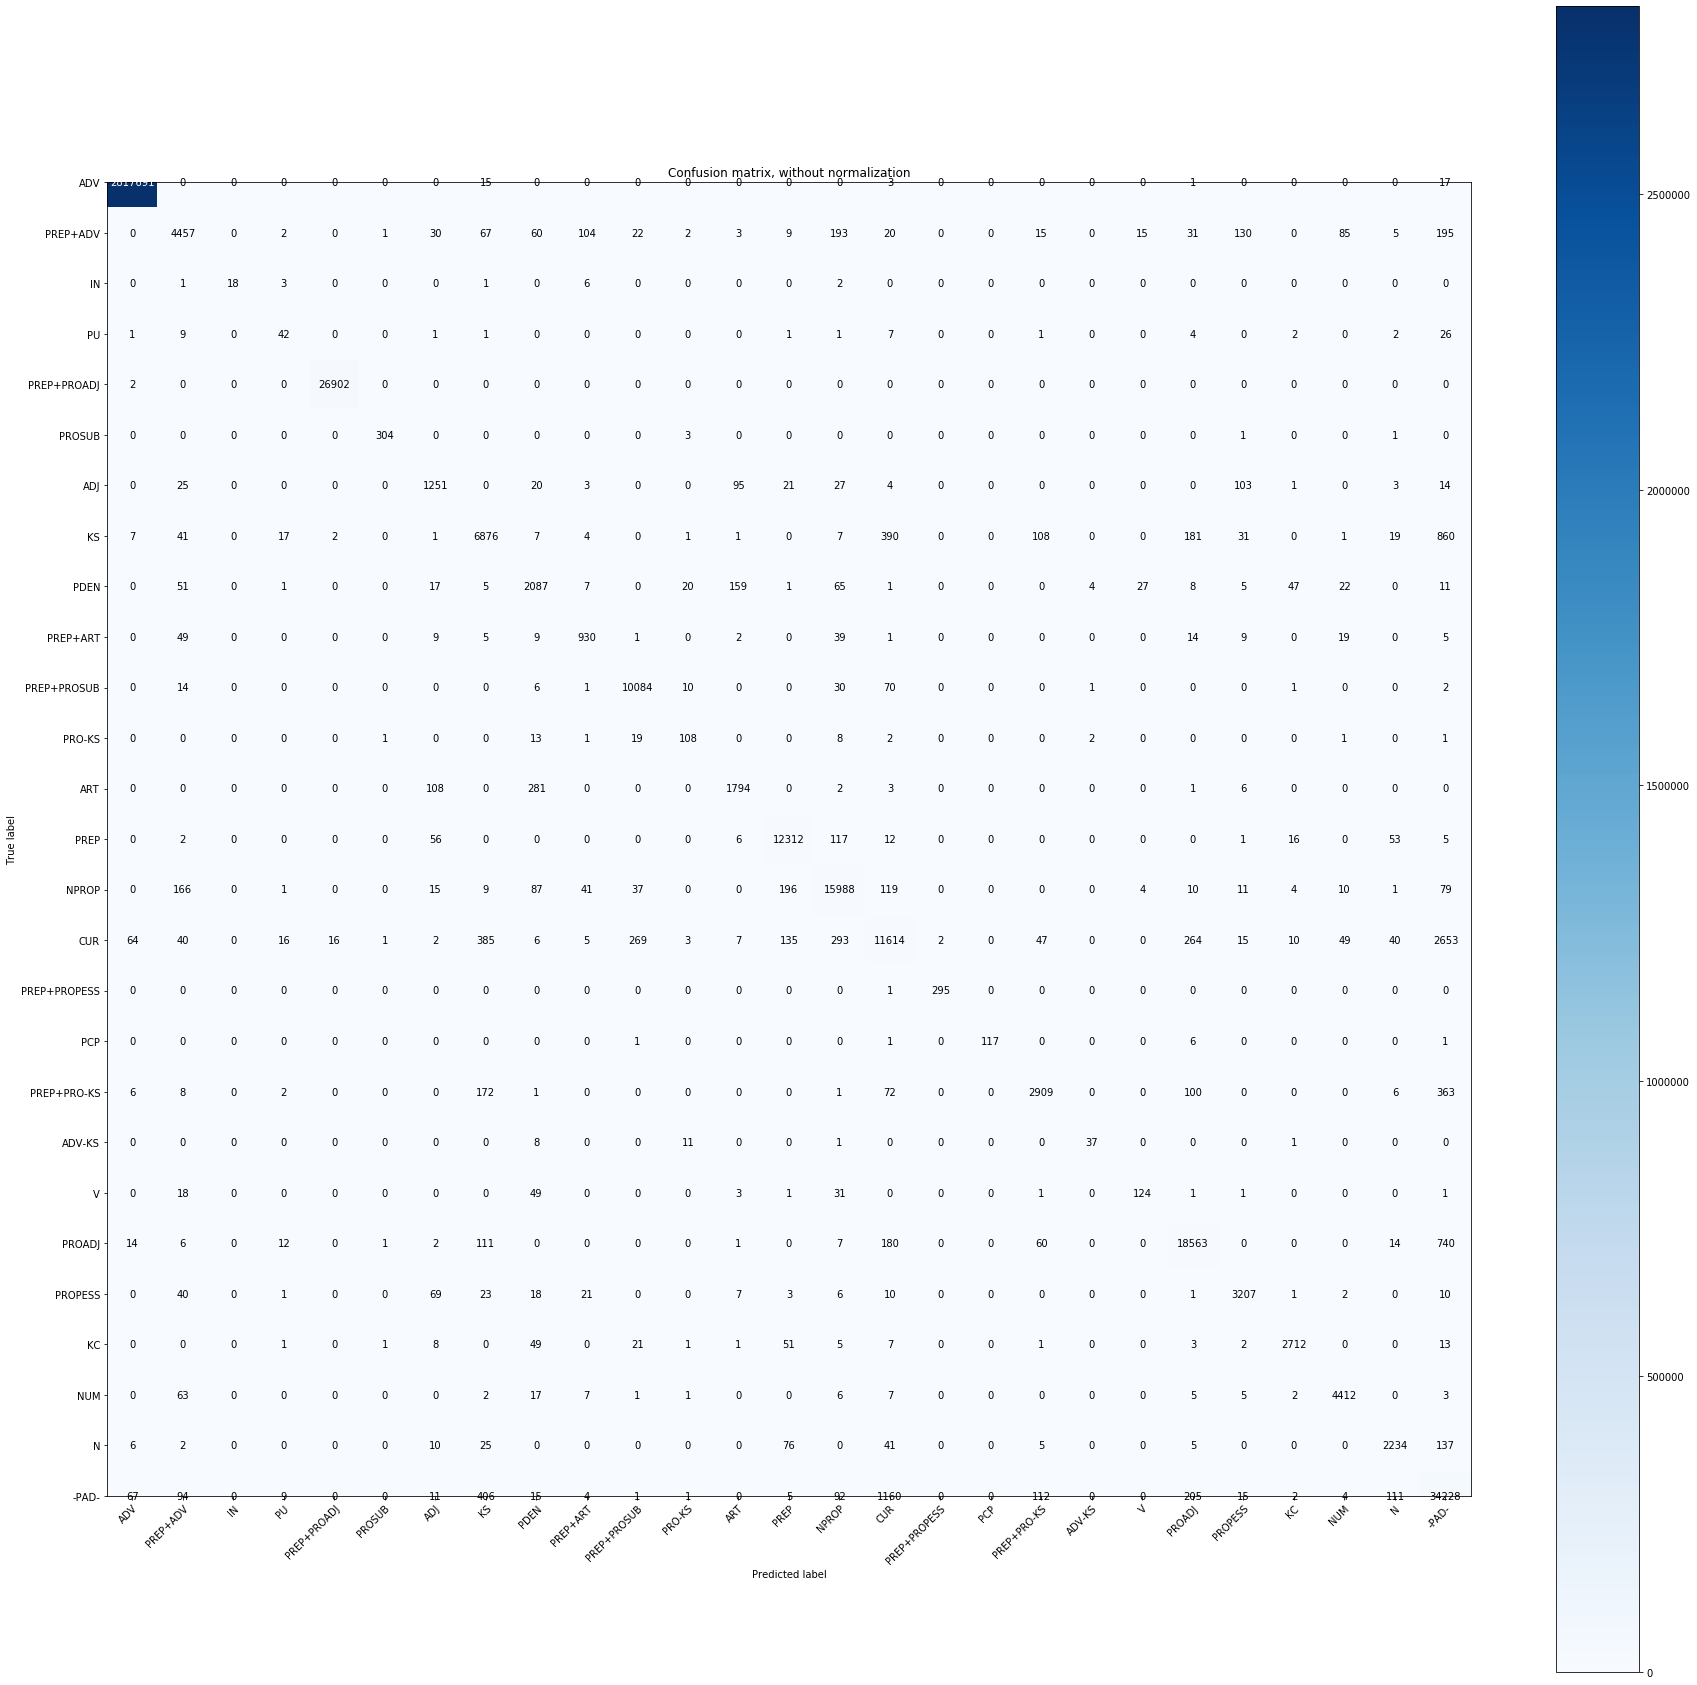

In [47]:
fig.set_figheight(40)
fig.set_figwidth(30)
fig

Normalized confusion matrix


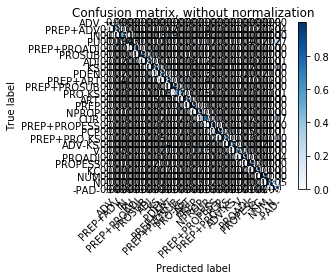

In [55]:
fig,ax = plot_confusion_matrix(y_true_plot, y_pred_plot, classes= labels, normalize=True,
                      title='Confusion matrix, without normalization')

## Confusion matrix normalized

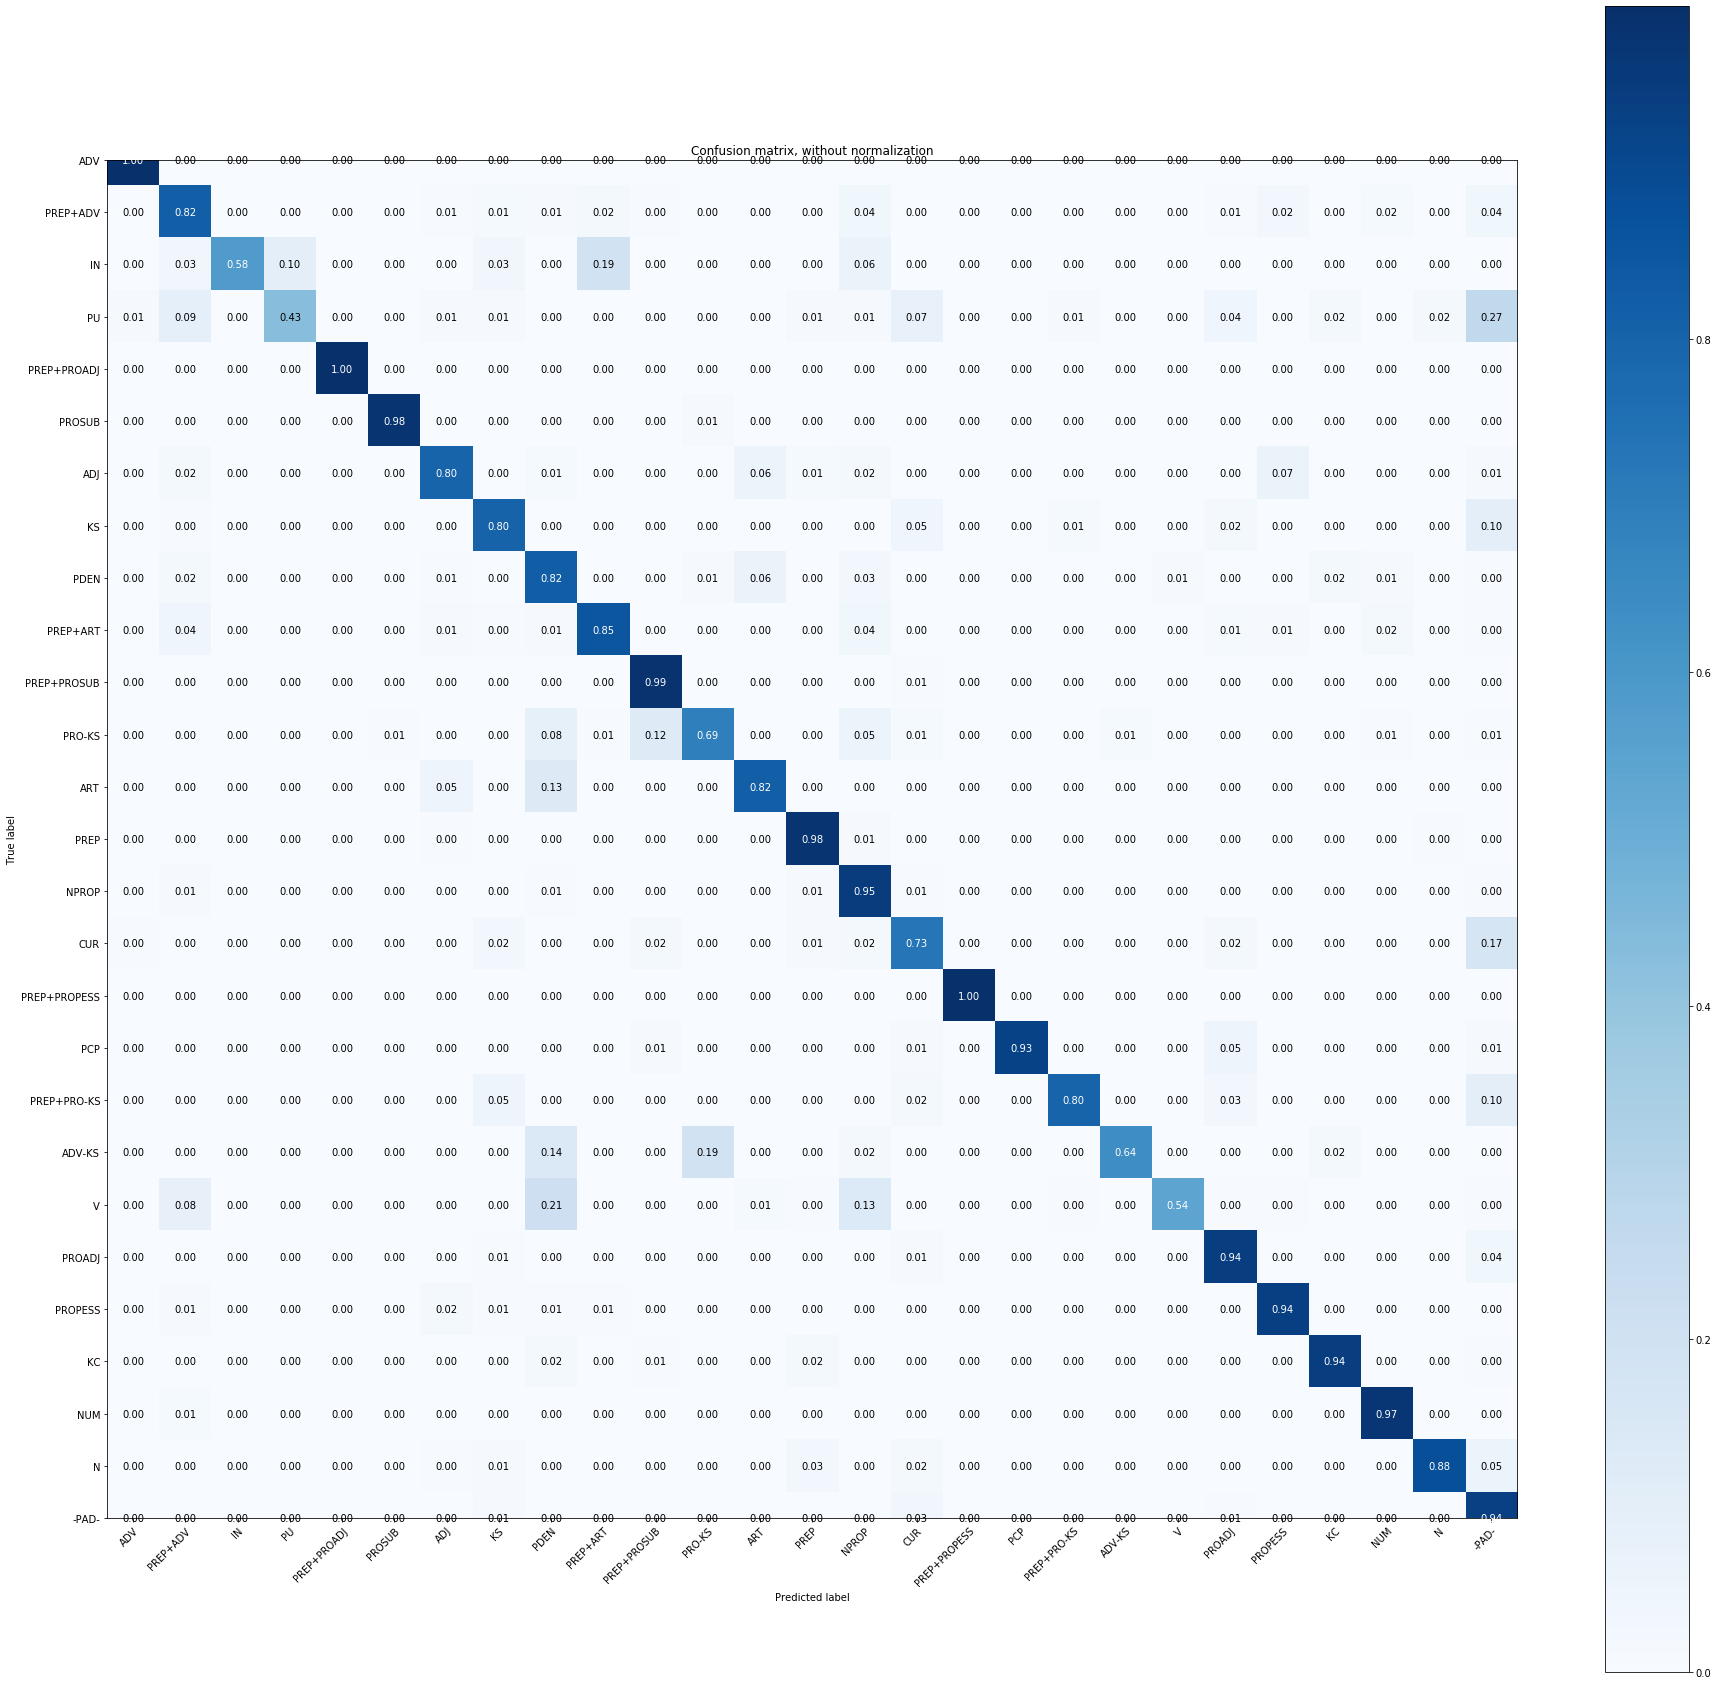

In [56]:
fig.set_figheight(40)
fig.set_figwidth(30)
fig

## Train data analysis

In [52]:
from collections import Counter

all_tags_train = np.concatenate(train_tags_y)

counter = Counter(all_tags_train)

counter.most_common()

[(0, 10655903),
 (26, 156121),
 (4, 106234),
 (21, 75935),
 (15, 72030),
 (14, 70759),
 (13, 53139),
 (10, 45690),
 (7, 32873),
 (1, 18409),
 (24, 17908),
 (18, 15082),
 (25, 12944),
 (22, 11397),
 (8, 9109),
 (12, 8278),
 (23, 8234),
 (6, 4553),
 (9, 4335),
 (16, 2063),
 (5, 1340),
 (20, 777),
 (11, 524),
 (17, 388),
 (3, 174),
 (19, 151),
 (2, 50)]

In [53]:
tag2index

{'ADV': 1,
 'PREP+ADV': 2,
 'IN': 3,
 'PU': 4,
 'PREP+PROADJ': 5,
 'PROSUB': 6,
 'ADJ': 7,
 'KS': 8,
 'PDEN': 9,
 'PREP+ART': 10,
 'PREP+PROSUB': 11,
 'PRO-KS': 12,
 'ART': 13,
 'PREP': 14,
 'NPROP': 15,
 'CUR': 16,
 'PREP+PROPESS': 17,
 'PCP': 18,
 'PREP+PRO-KS': 19,
 'ADV-KS': 20,
 'V': 21,
 'PROADJ': 22,
 'PROPESS': 23,
 'KC': 24,
 'NUM': 25,
 'N': 26,
 '-PAD-': 0}

# Conclusion

#### Padding

The TAG 0 (SPACE), are the largest amount, represents 93% of the data, and had 93% accuracy. In addition to the existing space, a large amount of space was added in the experiment to ensure the same size across sentences, this technique is called by the padding library, and the spaces were added to the right as padding until reaching the maximum length of 300 characters. Although necessary the amount of space is too high compared to the other words and unbalances the dataset.

#### Epoch.
The number of seasons was very important for the success of the experiment, when performed with only 3 seasons the confusion matrix was terrible.

#### Metric
An accuracy metric was required to be custom implemented because when the space was considered in training, the model result would get much worse, so the "Padding" space was excluded from training.


### The 3 best tags : ADV , PREP+PROADJ  e PREP+PROPESS

The 3 best accuracy ** achieved 100% success in the test ** and are:

Tag (1 - ADV) represents approximately 2% of training data.

The tag (5 - PREP + PROAD) represents less than 1% of the training data and obtained an accuracy of 100%.

Tag (17 - PREP + PROPESS) represents less than 1% of training data. It obtained a great accuracy of 100%.

It is not possible to conclude with complete certainty, but it may be that prepositions make tagging easier, as they are used in tags 5 and 17 that were analyzed above and both obtained maximum accuracy. Or maybe there is some similarity as the above tags are usually few characters long.


### The 3 worst tags :  PU, V e IN

The 3 worst accuracy, obtained accuracy equal to or less than 58% of success in the test and are:

Although tag (4 - PU) is the third largest data representation, representing 9% of training data. Obtained the worst accuracy, ** reaching 43% test accuracy **, this tag represents all power signals such as comma and full stop.

Although tag (21 - V) is the fourth highest data representativeness, it is the second worst accuracy ** achieved 54% test accuracy **. With approximately 7% of the data having the second worst accuracy, it goes bad to recognize verb

The tag (3 - IN) was the third worst accuracy, and ** obtained 58% test accuracy **, it has little representativeness, and the 3 that represents approximately 0% of the total data, because of this the INTERJECTION may have had a poor performance.


### Future Improvements 

You can also experiment with different architectures, transfer learning, increasing seasons and looking for more data to balance tags more evenly.



# Reference

https://medium.com/@cetinsamet/part-of-speech-pos-tagging-8af646a3d5bb

https://nlpforhackers.io/lstm-pos-tagger-keras/

http://repository.upenn.edu/cgi/viewcontent.cgi?article=1039&context=ircs_reports

http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

https://stackoverflow.com/questions/52980414/how-can-i-change-a-two-dimensional-array-to-one-dimensional